In [21]:
import pandas as pd
import os

folder_path = "."

file_names = [
    "d23_v3.csv", "d22_v3.csv", "d21_v3.csv", "d20_v3.csv", "d19_v3.csv", 
    "d18_v3.csv", "d17_v3.csv", "d16_v3.csv"
]

dfs = {}

for file in file_names:
    file_path = os.path.join(folder_path, file)
    df_name = file.replace("_v3.csv", "")
    dfs[df_name] = pd.read_csv(file_path)

print("Loaded DataFrames:")
print(list(dfs.keys()))


Loaded DataFrames:
['d23', 'd22', 'd21', 'd20', 'd19', 'd18', 'd17', 'd16']


In [22]:
combined_df = pd.concat([dfs[name] for name in dfs], ignore_index=True)
dfs['d23']['REGION'].unique()

array(['East Midlands', 'East of England', 'London', 'North East',
       'North West', 'South East', 'South West', 'West Midlands',
       'Yorkshire and The Humber', nan], dtype=object)

In [38]:
expected_regions = [
    "north east", "north west", "yorkshire and the humber", "east midlands",
    "west midlands", "east of england", "london", "south east", "south west"
]

combined_df["region"] = combined_df["region"].astype(str).str.strip().str.lower()

combined_df = combined_df[combined_df["region"].isin(expected_regions)]



In [39]:
import numpy as np

combined_df.columns = combined_df.columns.str.strip().str.lower()
combined_df["substance name"] = combined_df["substance name"].astype(str).str.lower()

target_df = combined_df[combined_df["substance name"] == "indeno(1,2,3-cd)pyrene"].copy()

target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors='coerce')
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors='coerce')

qty = target_df["quantity released (kg)"].dropna()
threshold = target_df["reporting threshold (kg)"].mean()

summary = {
    "Mean": qty.mean(),
    "Std Dev": qty.std(),
    "Min": qty.min(),
    "Max": qty.max(),
    "5th Percentile": np.percentile(qty, 5),
    "10th Percentile": np.percentile(qty, 10),
    "25th Percentile": np.percentile(qty, 25),
    "50th Percentile (Median)": np.percentile(qty, 50),
    "75th Percentile": np.percentile(qty, 75),
    "90th Percentile": np.percentile(qty, 90),
    "95th Percentile": np.percentile(qty, 95),
    "Reporting Threshold (mean)": threshold,
    "Nb of Obs": len(qty),
    "Nb Below Threshold": (qty < threshold).sum(),
    "Nb of Different Sites": target_df["site address"].nunique()
}

target_df["year"] = target_df["authorisation id / permit id"].str.extract(r'(\d{2})').astype(float) + 2000
mean_years_per_site = target_df.groupby("site address")["year"].nunique().mean()

urban_share = (target_df["region"].str.lower() == "urban").mean()

regions = [
    "north east", "north west", "yorkshire and the humber", "east midlands",
    "west midlands", "east of england", "london", "south east", "south west",
]
region_shares = {region.title(): (target_df["region"].str.lower() == region).mean() for region in regions}

years = list(range(2015, 2024))
year_shares = {str(year): (target_df["year"] == year).mean() for year in years}

wastewater_keywords = ["water", "wastewater", "sewerage"]
target_df["is_wastewater"] = target_df["operator name"].str.lower().apply(
    lambda x: any(word in x for word in wastewater_keywords)
)
wastewater_share = target_df["is_wastewater"].mean()

for k, v in summary.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")
print(f"Mean number of years per site: {mean_years_per_site:.2f}")
print(f"Share from urban areas: {urban_share:.2%}")
print("\n--- Region Shares ---")
for k, v in region_shares.items():
    print(f"{k}: {v:.2%}")
print("\n--- Year Shares ---")
for k, v in year_shares.items():
    print(f"{k}: {v:.2%}")
print(f"\nShare of wastewater company samples: {wastewater_share:.2%}")


Mean: 1.0490
Std Dev: 2.4880
Min: 0.0000
Max: 23.5000
5th Percentile: 0.0000
10th Percentile: 0.0000
25th Percentile: 0.0000
50th Percentile (Median): 0.0000
75th Percentile: 1.2800
90th Percentile: 2.5486
95th Percentile: 4.6675
Reporting Threshold (mean): 1.0000
Nb of Obs: 1106.0000
Nb Below Threshold: 713
Nb of Different Sites: 223.0000
Mean number of years per site: 1.01
Share from urban areas: 0.00%

--- Region Shares ---
North East: 6.69%
North West: 20.34%
Yorkshire And The Humber: 9.95%
East Midlands: 7.50%
West Midlands: 12.30%
East Of England: 12.66%
London: 5.15%
South East: 17.54%
South West: 7.87%

--- Year Shares ---
2015: 0.18%
2016: 10.31%
2017: 6.33%
2018: 0.00%
2019: 0.00%
2020: 3.44%
2021: 0.36%
2022: 0.72%
2023: 0.72%

Share of wastewater company samples: 78.75%


In [43]:
for df in dfs.values():
    df.columns = df.columns.str.strip().str.lower()
    df["quantity released (kg)"] = pd.to_numeric(df["quantity released (kg)"], errors="coerce").fillna(0)
    df["substance name"] = df["substance name"].astype(str).str.lower()

total_weight = 0
year_weights = {}

for year in ['d23', 'd22', 'd21', 'd20', 'd19', 'd18', 'd17', 'd16']:
    df = dfs[year]
    year_weight = df[df["substance name"] == "indeno(1,2,3-cd)pyrene"]["quantity released (kg)"].sum()
    year_weights[year] = year_weight
    total_weight += year_weight

print("Share of Indeno(1,2,3-cd)pyrene total weight by year:")
for year in year_weights:
    share = year_weights[year] / total_weight if total_weight > 0 else 0
    print(f"{year}: {share:.2%}")

target_df["quantity released (kg)"].sum()

Share of Indeno(1,2,3-cd)pyrene total weight by year:
d23: 13.31%
d22: 11.74%
d21: 13.76%
d20: 12.40%
d19: 11.91%
d18: 11.83%
d17: 12.02%
d16: 13.05%


1160.1932000000002

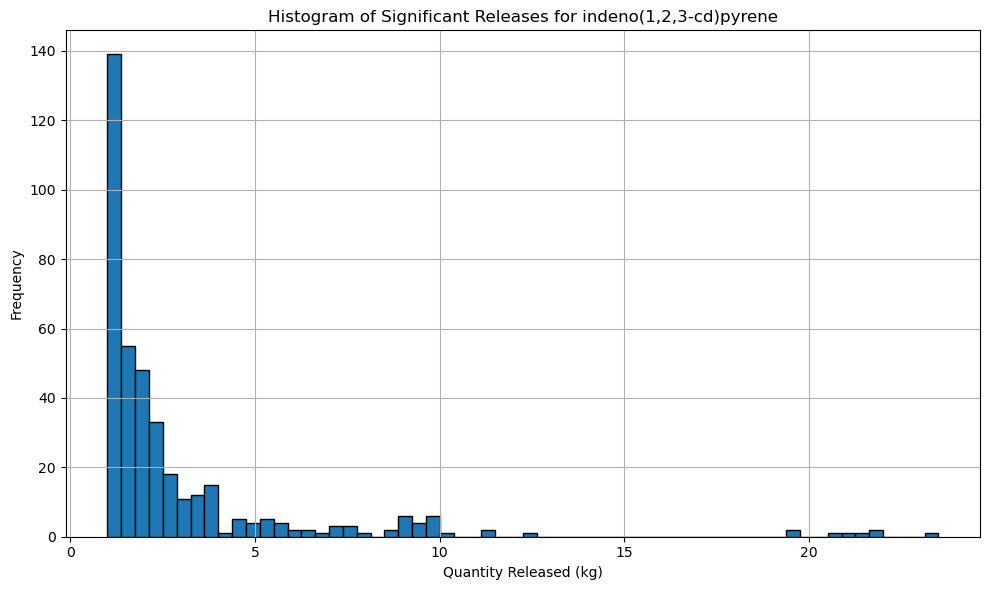

In [27]:

import matplotlib.pyplot as plt

combined_df.columns = combined_df.columns.str.strip().str.lower()

target_substance = "indeno(1,2,3-cd)pyrene"
target_df = combined_df[combined_df["substance name"].str.lower() == target_substance].copy()

target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors="coerce")
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors="coerce")

significant_df = target_df[
    target_df["quantity released (kg)"] > target_df["reporting threshold (kg)"]
].dropna(subset=["quantity released (kg)"])

plt.figure(figsize=(10, 6))
plt.hist(significant_df["quantity released (kg)"], bins=60, edgecolor='black')
plt.title(f"Histogram of Significant Releases for {target_substance}")
plt.xlabel("Quantity Released (kg)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
for year_str in ['d16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23']:
    dfs[year_str]['year'] = int('20' + year_str[1:])  # e.g. 'd16' → 2016
combined_df = pd.concat(dfs.values(), ignore_index=True)

In [29]:

import seaborn as sns

combined_df.columns = combined_df.columns.str.strip().str.lower()
combined_df["substance name"] = combined_df["substance name"].astype(str).str.lower()

target_df = combined_df[combined_df["substance name"] == "indeno(1,2,3-cd)pyrene"].copy()
target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors='coerce')
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors='coerce')
threshold = target_df["reporting threshold (kg)"].mean()

significant_df = target_df[target_df["quantity released (kg)"] > threshold]


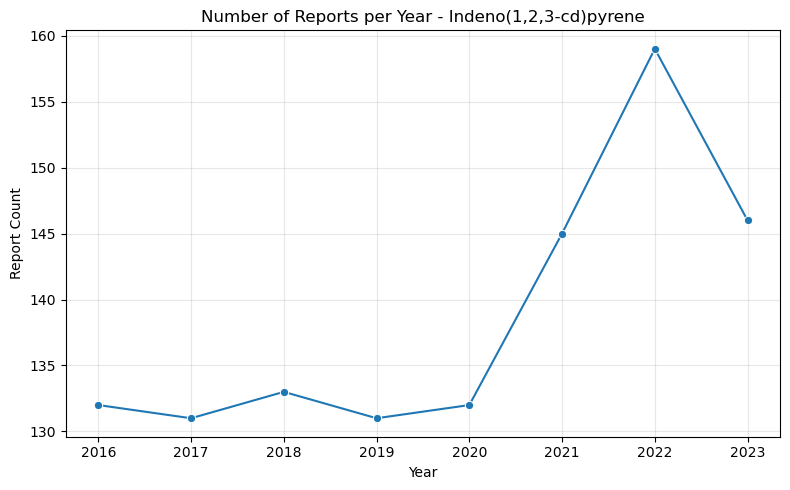

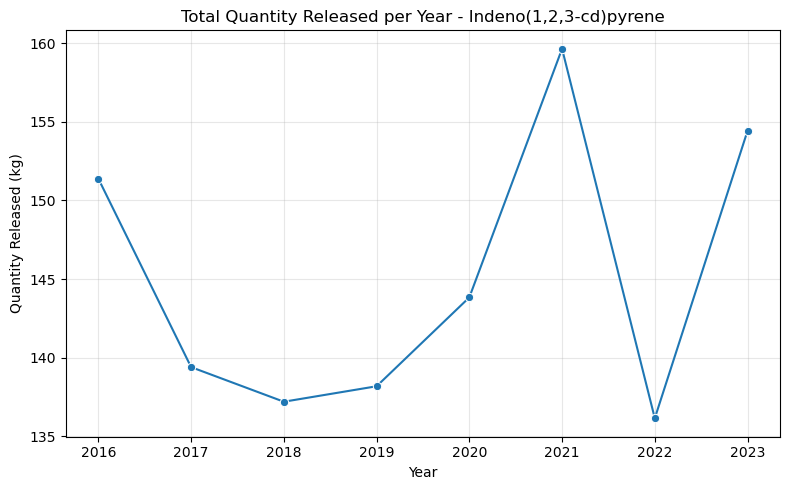

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

indeno_freq = target_df.groupby('year').size().reset_index(name='Report Count')

indeno_quantity = target_df.groupby('year')['quantity released (kg)'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=indeno_freq, x='year', y='Report Count', marker='o')
plt.title('Number of Reports per Year - Indeno(1,2,3-cd)pyrene')
plt.xlabel('Year')
plt.ylabel('Report Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(data=indeno_quantity, x='year', y='quantity released (kg)', marker='o')
plt.title('Total Quantity Released per Year - Indeno(1,2,3-cd)pyrene')
plt.xlabel('Year')
plt.ylabel('Quantity Released (kg)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


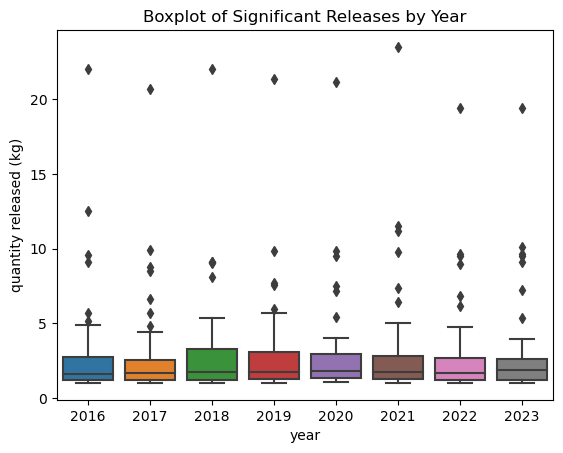

In [31]:
sns.boxplot(data=significant_df, x="year", y="quantity released (kg)")
plt.title("Boxplot of Significant Releases by Year")
plt.show()


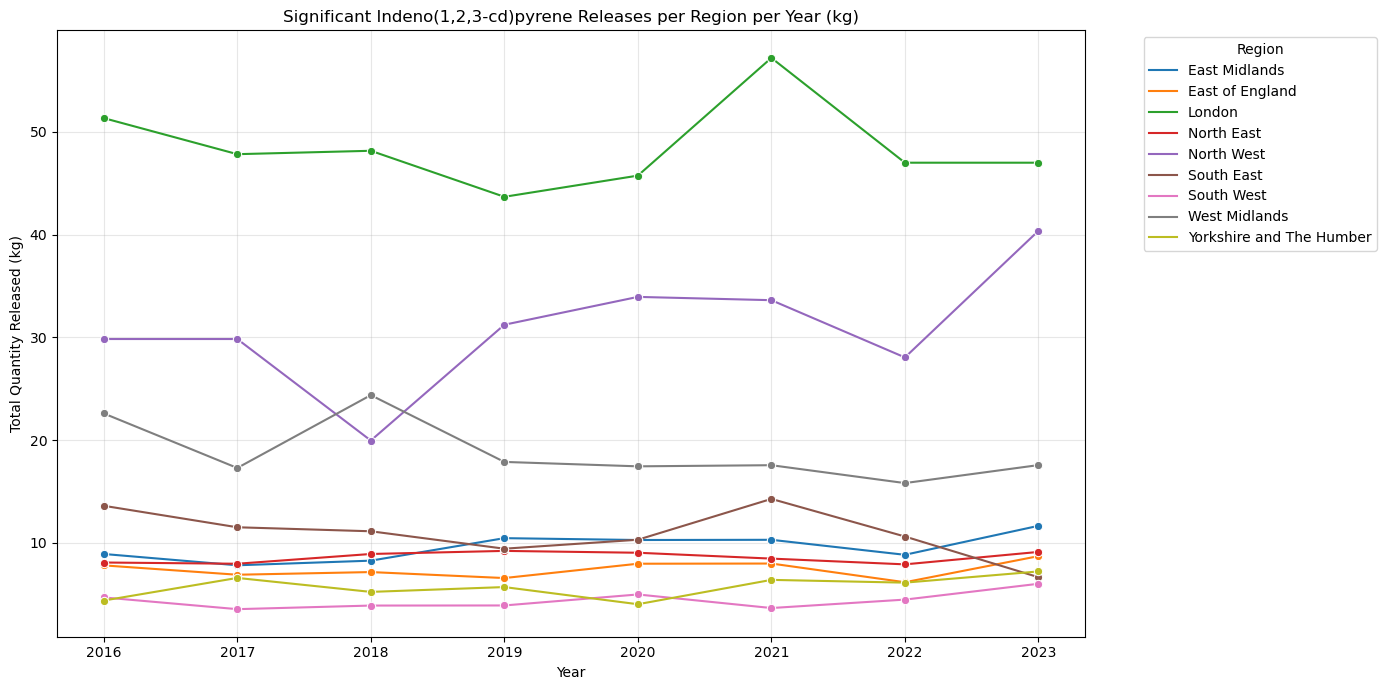

In [32]:
target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors='coerce')
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors='coerce')

significant = target_df[target_df["quantity released (kg)"] > target_df["reporting threshold (kg)"]]

region_year_quantity = (
    significant.groupby(["region", "year"])["quantity released (kg)"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 7))
sns.lineplot(data=region_year_quantity, x="year", y="quantity released (kg)", hue="region", marker="o")

plt.title("Significant Indeno(1,2,3-cd)pyrene Releases per Region per Year (kg)")
plt.xlabel("Year")
plt.ylabel("Total Quantity Released (kg)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


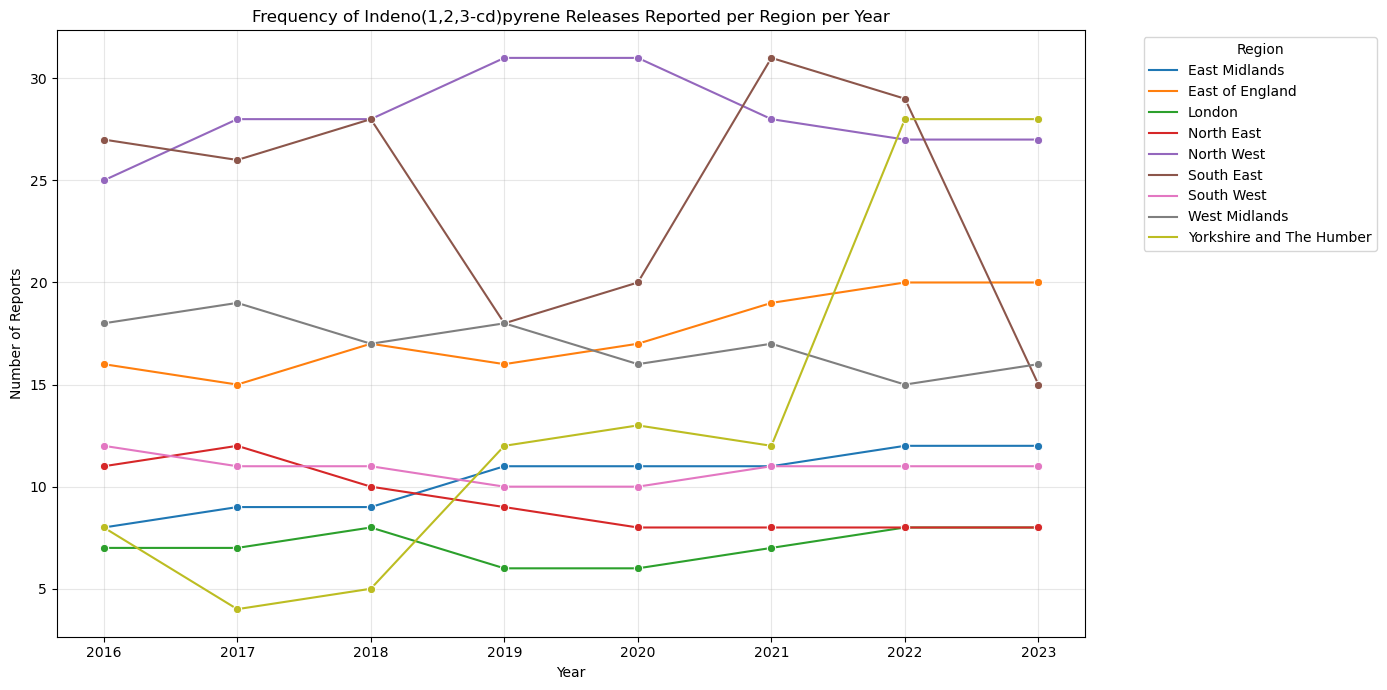

In [33]:
assert 'year' in target_df.columns and 'region' in target_df.columns, "Missing 'year' or 'region'."

release_counts = (
    target_df.groupby(["region", "year"])
    .size()
    .reset_index(name="release_count")
)

plt.figure(figsize=(14, 7))
sns.lineplot(data=release_counts, x="year", y="release_count", hue="region", marker="o")

plt.title("Frequency of Indeno(1,2,3-cd)pyrene Releases Reported per Region per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [34]:
target_df["operator name"] = target_df["operator name"].astype(str).str.strip().str.lower()

companies_by_year = target_df.groupby("year")["operator name"].nunique()
print("Unique companies per year:\n", companies_by_year)


Unique companies per year:
 year
2016    26
2017    23
2018    29
2019    35
2020    36
2021    37
2022    36
2023    35
Name: operator name, dtype: int64


In [35]:
companies_sets = {
    year: set(target_df[target_df["year"] == year]["operator name"].unique())
    for year in target_df["year"].unique()
}

years = sorted(companies_sets.keys())
common_companies = set.intersection(*(companies_sets[year] for year in years))

print(f"Companies reporting in all years ({len(common_companies)}):")
for company in common_companies:
    print("-", company)

overlap_counts = {}

for i in range(1, len(years)):
    year_a = years[i - 1]
    year_b = years[i]
    overlap = companies_sets[year_a].intersection(companies_sets[year_b])
    overlap_counts[f"{year_a}-{year_b}"] = len(overlap)

print("\nCompany overlaps between consecutive years:")
for k, v in overlap_counts.items():
    print(f"{k}: {v} companies")

nonzero_df = target_df[target_df["quantity released (kg)"] > 0]

num_companies = nonzero_df["operator name"].nunique()

print(f"Number of companies with significant emissions: {num_companies}")


Companies reporting in all years (9):
- phillips 66 limited
- anglian water
- severn trent water ltd
- northumbrian water ltd
- thames water utilities ltd
- wessex water
- south west water ltd
- united utilities water plc
- 3c waste limited

Company overlaps between consecutive years:
2016-2017: 19 companies
2017-2018: 20 companies
2018-2019: 22 companies
2019-2020: 29 companies
2020-2021: 31 companies
2021-2022: 28 companies
2022-2023: 24 companies
Number of companies with significant emissions: 14


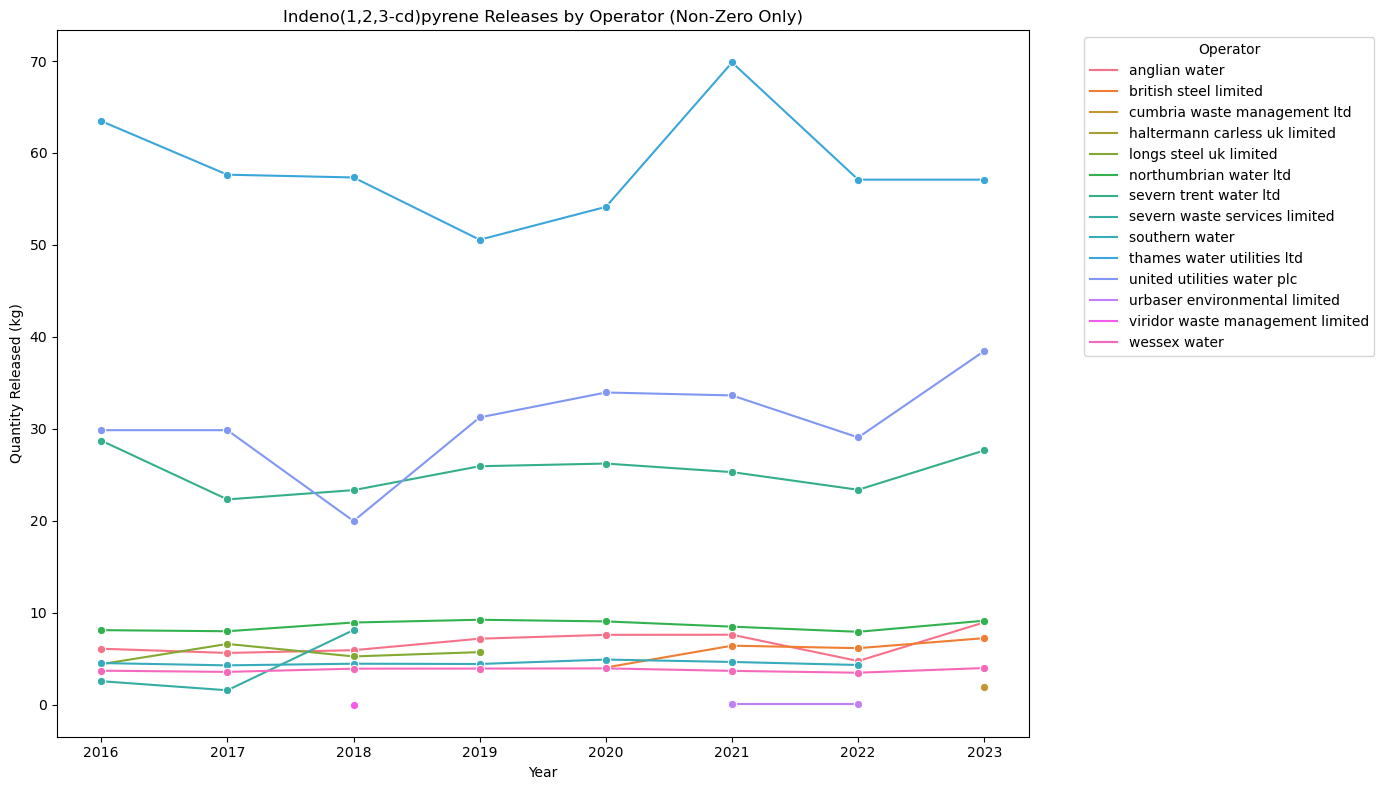

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

nonzero_df = target_df[target_df["quantity released (kg)"] > 0]

company_trends = (
    nonzero_df.groupby(["operator name", "year"])["quantity released (kg)"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=company_trends,
    x="year",
    y="quantity released (kg)",
    hue="operator name",
    marker="o"
)
plt.title("Indeno(1,2,3-cd)pyrene Releases by Operator (Non-Zero Only)")
plt.xlabel("Year")
plt.ylabel("Quantity Released (kg)")
plt.legend(title="Operator", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

target_substance = "benzo(a)pyrene"

csv_files = [
    "d16.csv", "d17.csv", "d18.csv", "d19.csv",
    "d20.csv", "d21.csv", "d22.csv", "d23.csv"
]

all_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip().str.lower()
    df = df[df['substance name'].str.lower() == target_substance]
    df['quantity released (kg)'] = pd.to_numeric(df['quantity released (kg)'], errors='coerce')
    df['reporting threshold (kg)'] = pd.to_numeric(df['reporting threshold (kg)'], errors='coerce')
    df = df[df['quantity released (kg)'] >= df['reporting threshold (kg)']]
    all_dfs.append(df)

combined_target = pd.concat(all_dfs, ignore_index=True)

num_companies = combined_target['operator name'].nunique()

print(f"Number of companies with significant emissions of Benzo(a)pyrene: {num_companies}")


Number of companies with significant emissions of Benzo(a)pyrene: 13
